In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
import seaborn as sns



In [3]:

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
print(f'Shape of train images: {train_images.shape}')
print(f'Shape of test images: {train_images.shape}')

Shape of train images: (60000, 28, 28)
Shape of test images: (60000, 28, 28)


In [5]:
# Изменение размера изображений и их нормализация

# Меняем размер изображений с (28, 28) на (32, 32) и добавляем 3 канала (RGB)

# Меняем размер изображений на 32x32 пикселя, чтобы они соответствовали входным требованиям модели.
train_images = tf.image.resize(np.array(train_images)[..., tf.newaxis], (32, 32))
# Добавляем 3 канала цвета (RGB), так как модель ожидает цветные изображения.
# Нормализуем пиксели, чтобы значения были от 0 до 1, что помогает модели обучаться лучше.
train_images = np.repeat(train_images, 3, axis=-1)
test_images = tf.image.resize(np.array(test_images)[..., tf.newaxis], (32, 32))
test_images = np.repeat(test_images, 3, axis=-1)

# Нормализуем значения пикселей от 0 до 1
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

# Проверяем размерности после изменения размера и нормализации
print(f'Shape of train images after resize and normalization: {train_images.shape}')
print(f'Shape of test images after resize and normalization: {test_images.shape}')

Shape of train images after resize and normalization: (60000, 32, 32, 3)
Shape of test images after resize and normalization: (10000, 32, 32, 3)


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker' , 'Bag', 'Ankle boot']

In [7]:
# Преобразуем метки классов в формат one hot, где каждая метка представлена в виде вектора с единицей на месте класса и нулями в остальных местах.
# Это нужно, чтобы модель могла правильно обучаться и делать прогнозы.

unique_classes = np.unique(train_labels)
NUM_CLASSES = unique_classes.shape[0]

def to_categorical(labels, num_classes):
  return tf.keras.utils.to_categorical(labels, num_classes)
train_labels = to_categorical(train_labels, NUM_CLASSES)
test_labels = to_categorical(test_labels, NUM_CLASSES)
print(train_labels.shape)
print(test_labels.shape)

(60000, 10)
(10000, 10)


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') - logs.get('val_accuracy') >= 0.05 and epoch > 5:
      # Stop if threshold is met
      print(f"\nThe difference between train accuracy and validation more than 5% so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [11]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
model_vgg = Sequential()
model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation="relu"))
model_vgg.add(Dense(10, activation="softmax"))

In [13]:
model_vgg.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(
    train_images,
    train_labels,
    epochs=25,
    verbose=1,
    batch_size=250,
    validation_split=0.2,
    callbacks=[callbacks, reduce_lr, early_stopping]
)

Epoch 1/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7330 - loss: 0.7762 - val_accuracy: 0.8287 - val_loss: 0.4730 - learning_rate: 0.0030
Epoch 2/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8401 - loss: 0.4299 - val_accuracy: 0.8483 - val_loss: 0.4161 - learning_rate: 0.0030
Epoch 3/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8594 - loss: 0.3784 - val_accuracy: 0.8518 - val_loss: 0.4056 - learning_rate: 0.0030
Epoch 4/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8668 - loss: 0.3594 - val_accuracy: 0.8575 - val_loss: 0.3852 - learning_rate: 0.0030
Epoch 5/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8740 - loss: 0.3413 - val_accuracy: 0.8555 - val_loss: 0.3975 - learning_rate: 0.0030
Epoch 6/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8796 - loss: 0.3244 - val_accuracy: 0.8637 - val_loss: 0.3722 - learning_rate: 0.0030
Epoch 7/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8821 - loss:

In [ ]:
# Вот что можно понять из ↑:
#  Модель обучалась 18 эпох (цикл), хотя планировалось 25.
#  Точность модели на обучающем наборе данных и на проверочном (валидационном) наборе данных увеличивалась с каждой эпохой.
#  Когда разница между точностью на обучающем наборе и проверочном стала больше 5%, обучение было остановлено.
#  На последних эпохах точность модели достигла около 93% на обучающем наборе и 88% на проверочном наборе
#  Модель обучилась хорошо, но чтобы избежать переобучения, обучение остановили раньше.

In [14]:
model_vgg.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8833 - loss: 0.3572


[0.3664781451225281, 0.8790000081062317]

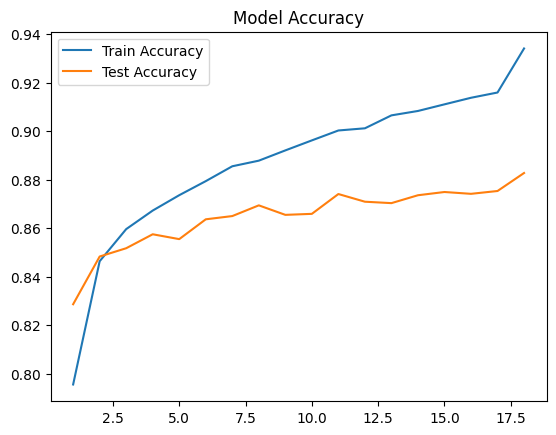

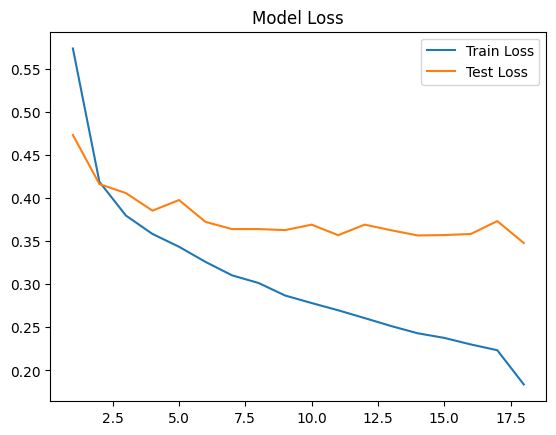

In [15]:
# Построение графиков
result = pd.DataFrame(history_vgg.history)  # Создаем таблицу с результатами обучения

# График точности модели
plt.plot(list(range(1, result.shape[0]+1)), result['accuracy'], label='Train Accuracy')  # Точность на тренировочных данных
plt.plot(list(range(1, result.shape[0]+1)), result['val_accuracy'], label='Test Accuracy')  # Точность на тестовых данных
plt.legend()  # Показываем легенду
plt.title('Model Accuracy')  # Заголовок графика
plt.show()  # Показываем график

# График потерь модели
plt.plot(list(range(1, result.shape[0]+1)), result['loss'], label='Train Loss')  # Потери на тренировочных данных
plt.plot(list(range(1, result.shape[0]+1)), result['val_loss'], label='Test Loss')  # Потери на тестовых данных
plt.legend()  # Показываем легенду
plt.title('Model Loss')  # Заголовок графика
plt.show()  # Показываем график

In [16]:
# обзор архитектуры модели
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Вот что можно понять из ↑:
# Модель VGG16 состоит из нескольких слоёв, которые обрабатывают изображения.
# У модели 14,7 миллионов параметров. Это числа, которые модель учит, чтобы лучше распознавать изображения.
# Из них только половина — обучаемые параметры (7 миллионов). Это те, которые мы можем изменять при обучении.
# Остальные параметры — не обучаемые. Это означает, что они уже настроены, и мы их не меняем, когда обучаем модель на новых данных.
# Модель большая и мощная, но требует много вычислений.

In [17]:
# Мы добавляем уникальные имена к каждому слою модели, чтобы их легче было отличать.
# Это нужно, чтобы знать, какой именно слой мы используем или изменяем.

# Создание нового списка слоев с уникальными именами
new_layers = []

# Обновление слоев модели
for i, layer in enumerate(conv_base.layers):
    layer.name = layer.name + 'layer' + str(i)  # Присваиваем уникальное имя
    new_layers.append(layer)

# Создание новой модели с обновленными слоями
x = Flatten()(new_layers[-1].output)  # Добавляем слой Flatten
x = Dense(256, activation='relu')(x)  # Добавляем Dense слой
output = Dense(NUM_CLASSES, activation='softmax')(x)  # Добавляем выходной слой

# Теперь каждый слой модели имеет уникальное имя, что помогает при работе с моделью и отслеживании её слоев.

In [18]:
# Печатаем имена всех слоев модели
for layer in model_vgg.layers:
    print(layer.name)

vgg16
flatten
dense
dense_1


In [19]:
# Модификация слоев VGG16
# Мы хотим заморозить (не обучать) все слои модели до слоя block5_conv1.
# Слои после block5_conv1 будут обучаться, чтобы они могли адаптироваться к нашим данным.
# Модель будет обучать только последние слои, что позволяет сохранить уже обученные слои и улучшить обучение на новых данных.

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))  # Загружаем VGG16 без верхних слоев
set_trainable = False  # Сначала не разрешаем обучение слоям
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':  # Находим слой с именем 'block5_conv1'
        set_trainable = True  # Разрешаем обучение после этого слоя
    if set_trainable:
        layer.trainable = True  # Разрешаем обучение слоям после 'block5_conv1'
    else:
        layer.trainable = False  # Не разрешаем обучение слоям до 'block5_conv1'

In [20]:
# Создание и компиляция модифицированной модели

# Мы создаём новую модель, которая включает предобученную часть VGG16 и добавляем собственные слои для классификации.
modified_model = tf.keras.models.Sequential([
    conv_base,  # Используем предобученную часть модели VGG16
    Flatten(),  # Преобразуем 3D-данные в 1D
    Dense(256, activation='relu'),  # Добавляем полносвязный слой с 256 нейронами и функцией активации ReLU
    Dense(NUM_CLASSES, activation='softmax'),  # Добавляем выходной слой с количеством нейронов, равным числу классов, и функцией активации Softmax
])

# Мы компилируем модель, чтобы она могла обучаться и оцениваться на данных.
modified_model.compile(
    optimizer=Adam(learning_rate=0.000024),  # Оптимизатор Adam с маленькой скоростью обучения
    loss='categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    metrics=['accuracy']  # Метрика точности для оценки модели
)
# Модель готова к обучению и оценке. Она будет использовать VGG16 для извлечения признаков и добавленные слои для классификации изображений.

In [21]:
# Обучение модифицированной модели
# Мы обучаем модифицированную модель на обучающих данных.
# Используем проверки, чтобы следить за процессом обучения и автоматически останавливать его при необходимости.
history_vgg = modified_model.fit(
    train_images,  # Обучающие изображения
    train_labels,  # Метки для обучающих изображений
    epochs=25,  # Количество эпох (сколько раз модель будет проходить через все данные)
    verbose=1,  # Показ подробной информации о процессе обучения
    batch_size=250,  # Размер батча (количество изображений для обработки за один раз)
    validation_split=0.2,  # Доля данных, используемая для проверки модели (20%)
    callbacks=[callbacks, reduce_lr, early_stopping]  # Используемые функции для улучшения обучения
)

Epoch 1/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.6778 - loss: 1.0291 - val_accuracy: 0.8633 - val_loss: 0.3747 - learning_rate: 2.4000e-05
Epoch 2/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.8742 - loss: 0.3414 - val_accuracy: 0.8842 - val_loss: 0.3224 - learning_rate: 2.4000e-05
Epoch 3/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8931 - loss: 0.2921 - val_accuracy: 0.8907 - val_loss: 0.2964 - learning_rate: 2.4000e-05
Epoch 4/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9084 - loss: 0.2594 - val_accuracy: 0.8922 - val_loss: 0.2969 - learning_rate: 2.4000e-05
Epoch 5/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9095 - loss: 0.2458 - val_accuracy: 0.9003 - val_loss: 0.2757 - learning_rate: 2.4000e-05
Epoch 6/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9197 - loss: 0.2240 - val_accuracy: 0.9034 - val_loss: 0.2645 - learning_rate: 2.4000e-05
Epoch 7/25
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step -

In [22]:
model_vgg.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8833 - loss: 0.3572


[0.3664781451225281, 0.8790000081062317]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


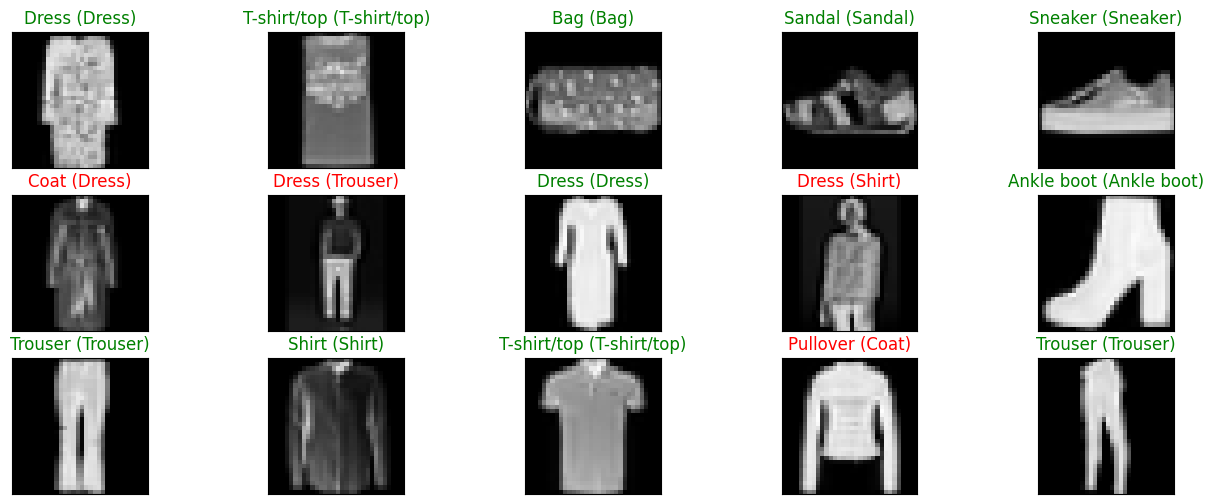

In [23]:
predictions = model_vgg.predict(test_images)  # Получаем предсказания модели для всех тестовых изображений

figure = plt.figure(figsize=(16, 6))  # Создаем фигуру для отображения изображений
display_images = np.random.choice(test_images.shape[0], size=15, replace=False)  # Выбираем случайные 15 изображений из тестового набора

for i, index in enumerate(display_images):  # Для каждого случайного изображения:
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])  # Добавляем изображение в сетку 3x5, убираем оси
    ax.imshow(test_images[index], cmap='gray')  # Показываем изображение в оттенках серого
    predict_index = np.argmax(predictions[index])  # Определяем класс, который предсказала модель
    #print(f'{predict_index}: {class_names[predict_index]}')
    true_index = np.argmax(test_labels[index])  # Определяем истинный класс изображения
    # В заголовке отображаем предсказанный и истинный классы. Если предсказание верно — цвет зеленый, если нет — красный.
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [25]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.86      0.83      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.82      0.80      0.81      1000
       Dress       0.87      0.85      0.86      1000
        Coat       0.78      0.79      0.79      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.69      0.67      0.68      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



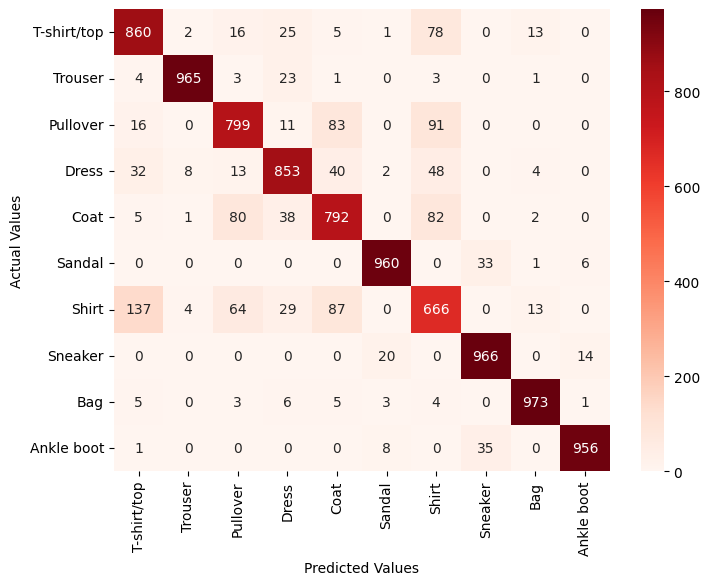

In [26]:
cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Як бачимо VGG16 має точніть на 2% нижче за FCNN (з попереднього ДЗ) і на 6% нижче ніж CNN з частини 1. Згідно результатів Classification Report і Confusion Matrix наша нейромережа добре справилася з розпізнаванням усіх зображень одягу. Найбільшу точність вона показала при розпізнаванні зображень Bag, Trouser, а найменшу для зображень Shirt. VGG16 — це глибока модель із великою кількістю параметрів, розроблена для більш складних наборів даних, таких як ImageNet, який містить мільйони зображень із високою роздільною здатністю та різноманітним вмістом. З іншого боку, Fashion MNIST — це відносно простий набір даних із невеликими зображеннями у градаціях сірого (28x28 пікселів) і меншою кількістю класів (10 категорій одягу). Висока ємність VGG16 може призвести до переобладнання цього менш складного набору даних.